# Investigating Heat Transfer as a Function of Changing Volume
November 4, 2018

Duncan Mazza and Deborah Bowen

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import pandas as pd
from scipy import stats
import numpy as np

# Question
The phenomenon in question is a universal one - one that anyone who consumes hot beverages experiences on a regular occurrence: As a hot drink is being consumed, the liquid loses heat faster as less volume remains. The resulting experience is a drink that grows colder faster the more rapidly it is consumed. Thus, we set out to answer the questions: 
1. How can this relationship between changing volume and changing rate of temperature drop be qualitatively explained?
2. Can we predict the final temperature of a fluid at a given time based on its starting temperature, the temperature of its environment, the heat transfer coefficient specific to its container, the dimensions of the container (a rectangular prism with a square base), and its rate of change of volume (assumed to be constant)?

# Model
To answer these questions, we start with $dTdt = -r * (T - T_{env})$ where $T_{env}$ is the temperature of the environment, and $r$ is a constant that represents: $(h*A)/(C*m)$ where $h$ is the heat transfer coefficient, $A$ is the surface area of convection, $C$ is the specific heat of water, and $m$ is the mass of the water. Thus, $r$ can be represented as a function of the volume of water. The following assumptions are made in our model: 
1. The heat transfer is assumed to be constant over all surfaces of the container, which in the physical world isn't true. The heat transfer coefficient is different depending on whether the water is in contact with the air or with the walls of the container. Because the container we are modeling is a plastic container and therefore of low conductivity, we believe this is negligible. 
2. Because the dimensions of the container must be defined to avoid a two-dimensional function, we reference the container used in the later experiment: a 0.13m x 0.13m x 0.05m plastic container.
3. Because the heat transfer constant is an empirically determined value, we chose the value of `h = 0.09` to match our mathematical model as close as possible to our empirical model (seen later in the essay). 
While this is an empirically-driven mathematical model, these values must be measured to achieve a two-dimensional result. Thus, our results are constrained to interpretation only in the context of our specific container, but the model is flexible enough to accommodate any container so long as the empirical information is supplied.

The function that takes $V$ as an argument and returns $r$ is shown below:

In [2]:
# Function of r using math:
def r_math(V):

    if V > 0:
        # size of box:
        x = .13
        
        mass = V*0.001

        # heat transfer coefficient between air and water
        h = 0.09
        # heat capacity of water
        C = 4.184

        # surface area as a function of volume (volume in the equation is in 
        # kiloliters, so it needs to be converted to milliliters)
        SA = 2 * (x**2) + (4 * (V * 0.000001)) / x
    
    else:
        x = .13
        mass = .001
        h = 0.09
        C = 4.184
        SA = 2 * (x**2) + (4 * (V * 0.000001)) / x
    return ((h * SA)/(C * mass))

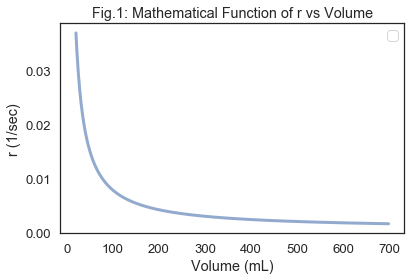

In [3]:
# Visualizing r_math:
listv = []
listr = []
for V in range(20, 700):
    listv.append(V)
    listr.append(r_math(V))
    
plot(listv, listr)
decorate(xlabel = 'Volume (mL)',
         ylabel = 'r (1/sec)',
         title = 'Fig.1: Mathematical Function of r vs Volume')

When using $dTdt$ to update the temperature stock of the water, instead of passing in `r` as a constant, it is passed in as the function `r_math` evaluated at the volume `V` at the given time step. The volume too doesn't remain constant because it is being swept; the volume is passed in by `dVdt`. 

In [4]:
def update_func(state, t, system, dvdt, r_math, math = True, 
                r_linear_function = r_math, slope = 0, intercept = 0):
    """Update the thermal transfer model.
    
    State objects:
    Temperature of vessel
    Volume of vessel
    
    t --> time
    T --> Temperature
    
    returns: State object containing the stocks
    """
    unpack(system)
    
    T = state.T
    V = state.V
    
   
    if(math == False):
         # Empirically determined function of r vs. V, used later in the essay
        r = unflipper(r_linear_function, slope, intercept, state.V)
    else:
        # Mathematically defined r value
        r = r_math(state.V)
        
    dTdt = -r * (T - T_env)
    # dvdt is passed in as an argument - it is being swept. 
    # We round it to two decimal points.
    dvdt = round(dvdt, 2)

    if(V > 0 and T > 25):
        T += dTdt * dt
        V += dvdt * dt
    else:
        V = 0
        T = None
    return State(T = T, V = V)

In [5]:
def run_simulation(system, update_func, dvdt, r_function, math = True, 
                   r_linear_function = r_math, slope = 0, intercept = 0):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[0] = init
    ts = linrange(0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system, dvdt, 
                                      r_function, 
                                      math = math, 
                                      r_linear_function = r_linear_function, 
                                      slope = slope, 
                                      intercept = intercept)
    
    # Store the final temperature in T_final
    system.T_final = get_last_value(frame.T)
    
    return frame

In [6]:
def make_system(T_init, V_init, dvdt):
    """Makes a System object with the given parameters.

    T_init: initial temperature in °C
    V_init: initial volume in mL
    r: heat transfer rate - when run, a function of r will be substituted in for it
    t_end: end time of simulation
    T_env: temperature of the environment
    dt: time step
    
    returns: System object
    """
    init = State(T = T_init, V = V_init)
    
    # T_final is used to store the final temperature.
    # Before the simulation runs, T_final = T_init
    # We do the same thing for Volume
    T_final = T_init
    V_final = V_init
    
    T_env = 25
    dt = 1
    
    # n_sweep stands for the number of sweeps that the model will perform
    n_sweep = 9
    
    # t_end stands for the number of seconds that the 
    # simulation will be run for
    t_end = 600
    
    '''
    Used at the end of this simulation, this is the threshold 
    that determines what rates of volume change over a given
    time period will result in a temperature at or over 40°C.
    '''
    minimum_acceptable_temp = 40
    
    return System(locals())

system = make_system(85, 700, -1);

In [7]:
def sweepdVdt(system, math = True):
    sweep = SweepSeries()
    dvdt_range = linspace(-5,0,system.n_sweep)
    
    # Check if the function is being called for a mathematical or empirical 
    # sweep, then run the simulation for the range of dVdt
    if(math):
        for t in range(0, system.n_sweep):
            dvdt = dvdt_range[t]
            sweep[t] = run_simulation(system, update_func, dvdt, r_math)
    else:    
        for t in range(0, system.n_sweep):
            dvdt = dvdt_range[t]
            sweep[t] = run_simulation(system, update_func, dvdt, unflipper, 
                                      math = False, 
                                      r_linear_function=r_linear_function, 
                                      slope=slope, intercept=intercept)
    return sweep

swept = sweepdVdt(system);

### Qualitative Result of Mathematical Model:

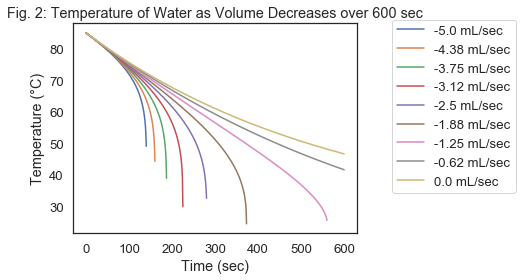

In [8]:
dvdt_range = linspace(-5, 0, system.n_sweep)
fig = plt.figure()
ax = plt.subplot(111);
for i in range(system.n_sweep):
    dvdt = round(dvdt_range[i], 2)
    ax.plot(swept[i].index, swept[i].T, label = str(dvdt) + ' mL/sec')
    decorate(xlabel = 'Time (sec)',
            ylabel = 'Temperature (°C)',
            title = 'Fig. 2: Temperature of Water as Volume Decreases over'
             ' {} sec'.format(system.t_end))
    ax.legend(bbox_to_anchor=(1.1, 1.05))

The qualitative result appears to validate our experiences with consuming hot liquids: the higher the rate of change of volume, the quicker the drop in temperature. However, because this is a mathematical model, when the volume is zero, an infinite slope of temperature over time results. This is not something that is observed in the physical world and is a shortcoming of the mathematical model.

### Quantitative Result of Mathematical Model
The final temperatures of each $dvdt$ sweep are plotted below, along with a `minimum_acceptable_temperature.` The following code exists to extract those final temperatures, and the `minimum_acceptable_temperature.` represents an arbitrary threshold that can be set to determine what rates of change of volume will yield the desired temperature. It is important to note that the following results are specific to not only the container used for the experiment but also the 600 second time frame that is modeled. 

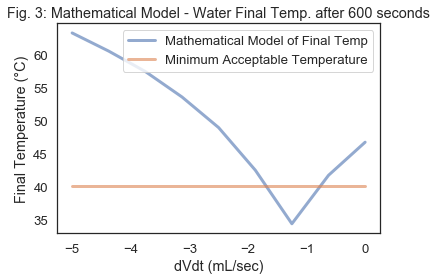

In [45]:
# Creating the time series in which the last temperatures from each dVdt 
# sweep will be stored.
last_temp = TimeSeries()

def determine_last_temp(last_temp, system, swept):
    '''
    Selecting the last values from each sweep by selecting the temperature 
    associated with the point at which the volume first hits 0 mL. If the 
    volume never reaches 0, the last temperature is still selected. 
    '''
    for i in range(system.n_sweep):
        for t in range(system.t_end):
            if (40<=swept[i].V[t]<=50 or t == system.t_end - 1):
                last_temp[i] = swept[i].T[t-1]
                break
    return last_temp

last_temp = determine_last_temp(last_temp, system, swept)

'''
To plot the data against dVdt and not against the sweep numbers, the dVdt 
values and last temperature values will be converted into lists and then 
plotted against each other.
'''
dvdt_list = []
last_temp_list = []

for i in range(len(dvdt_range)):
    dvdt_list.append(dvdt_range[i])
    last_temp_list.append(last_temp[i])

def plot_final_temp_and_minimum_acceptable_temp(dvdt_list, last_temp_list,
                                                minimum_acceptable_temp, label):
    plot(dvdt_list, last_temp_list, label = label)
    
    '''
    The minimum acceptable temperature will be plotted as a line. 
    To achieve this, a list of length len(dvdt_range) will created 
    and contain the minimum acceptable temperature in each index. 
    '''
    minimum_acceptable_temp_list = list()
    for i in range(len(dvdt_range)):
        minimum_acceptable_temp_list.append(minimum_acceptable_temp)
    plot(dvdt_list, minimum_acceptable_temp_list, 
         label = 'Minimum Acceptable Temperature')
    return minimum_acceptable_temp_list

plot_final_temp_and_minimum_acceptable_temp(dvdt_list, 
                                            last_temp_list, 
                                            minimum_acceptable_temp,
                                            'Mathematical Model of Final Temp')                              
decorate(xlabel = 'dVdt (mL/sec)', 
         ylabel = 'Final Temperature (°C)',
         title = 'Fig. 3: Mathematical Model - Water Final Temp. after'
         ' {} seconds'.format(system.t_end))

This graph illustrates that, given enough parameters/information about a specific container, the final temperature can be predicted based on the rate of change of volume of the container. A minimum is expected to occur at approximately $dVdt$ = -2 because that indicates a cusp at which the container will either have zero or nonzero volume remaining (to the right and left of the cusp respectively). This mathematical model will be further analyzed in comparison to the following empirical model.    

# Validation of Mathematical Model - Repeating  Model using Empirical Data

In order to empirically obtain a graph of the heat transfer coefficient as a function of volume, we obtained a series of empirically determined $r$ values (specific to the container used in the experiments) at different volumes. Eleven different volumes in total were used, and to calculate the r value, the following procedure was used: 
1. Set up the experiment: connect a thermistor to a breadboard such that it is the second resistor in the voltage
divider. The voltage divider must be connected to a 5V power supply and ground, and the first resistor must have a 
resistance of 1kΩ. Measure the voltage drop across the voltage divider.  
2. Bring water to near-boiling temperature.
3. Pour water into container on a scale until the desired mass/volume of water is achieved
4. Insert the thermistor into the water.
5. Record the starting voltage, as well as the voltage after 5 minutes.
6. Convert the voltage to temperature using the following equation:
    $T = (ln(5/Voltage - 1)/3528 + 1/298)^{-1} - 273$
7. Calculate an r value using the following equation:
    $r = 1 / t_{end} * log((T_{init} - T_{env})/(T_{end} - T_{env}))$
8. Repeat steps 2-7 for as many changes in volume are desired.

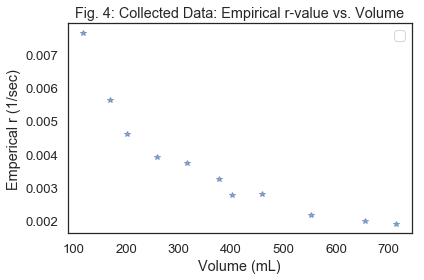

In [51]:
# A list of the data collected in our experiments. Each volume has 
# a corresponding calculated r value
data = {'Volume': [118.354, 169.507,202.606,258.774,316.948,377.128,
                   401.2,458.371,551.65,654.959,714.136], 
             'r': [0.007660215,0.00563342,0.004614561,0.003912183,
                   0.003744291,0.003259004,0.002769218,
                   0.002814454,0.002157224,0.001998175,0.001906878]}
# Creating a DataFrame from our collected data:
r_vs_volume_data = pd.DataFrame(data=data);

plot(r_vs_volume_data['Volume'], r_vs_volume_data['r'], '*')
decorate(xlabel = 'Volume (mL)', ylabel = 'Emperical r (1/sec)', 
         title = "Fig. 4: Collected Data: Empirical r-value vs. Volume")

### Finding a curve of best fit for the data.

In [52]:
'''
In order to find a best fit curve, we first linearize the data in data2, 
then create r_vs_volume_transformed_data as the DataFrame that 
contains the linearized data.
'''
data2 = {'Volume': r_vs_volume_data['Volume'], 
         'Transformed r': 1 / r_vs_volume_data['r']}
r_vs_volume_transformed_data = pd.DataFrame(data=data2);

'''
Code for plotting the results of the above:

plot(r_vs_volume_transformed_data['Volume'], 
     r_vs_volume_transformed_data['Transformed r'], '*')
decorate(xlabel = 'Volume (mL)', ylabel = 'Linearized r (sec)', 
         title = "Experimental Data: Linearized r vs. Volume")
''';

In [53]:
# Calculate a linear best fit line for the transformed data
x = r_vs_volume_transformed_data['Volume']
y = r_vs_volume_transformed_data['Transformed r']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

#Create the line from calculated slope and intercept
def r_linear_function(slope, intercept, volume):
    r = slope * volume + intercept
    return r

'''
Code for plotting the results of the above:

r_plot = r_linear_function(slope, intercept, 
                           r_vs_volume_transformed_data['Volume'])

def plot_linear_on_data(r_plot):
    plot(r_vs_volume_transformed_data['Volume'], 
         r_vs_volume_transformed_data['Transformed r'], '*', label = "Data")
    plot(r_vs_volume_transformed_data['Volume'], 
         r_plot, label = "Line of Best Fit")
    decorate(xlabel = 'Volume (mL)', ylabel = 'Linearized r', 
             title = "Line of Best fit with Linearized Data")  
plot_linear_on_data(r_plot)
''';

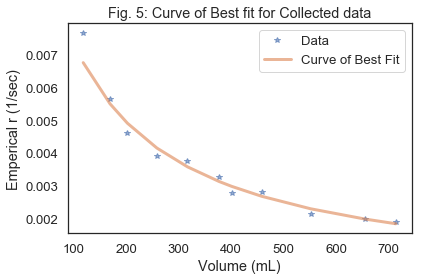

In [54]:
# De-linearizes the data and the line of best fit to give the best fit curve, 
# returns the curve:
def unflipper(r_linear_function, slope, intercept, volume):
    r = r_linear_function(slope, intercept, volume) ** -1
    return r

r_nonlinear_function = unflipper(r_linear_function, slope, intercept, 
                                 r_vs_volume_transformed_data['Volume'])

# Plots the curve of best fit with the data collected:
def plot_nonlinear_on_data(r_nonlinear_function):
    plot(r_vs_volume_data['Volume'], r_vs_volume_data['r'], 
         '*', label = "Data")
    plot(r_vs_volume_data['Volume'], r_nonlinear_function, 
         label = "Curve of Best Fit")
    decorate(xlabel = 'Volume (mL)', ylabel = 'Emperical r (1/sec)', 
             title = 'Fig. 5: Curve of Best fit for Collected data')

plot_nonlinear_on_data(r_nonlinear_function)

As expected, this curve closely resembles the mathematical one defined earlier, both in shape and in values, due to the fact that the mathematical model was calibrated to match this function. 

### Qualitative Result of Empirical Model

Now, the simulation is run again with the empirically determined $r$ as a function of volume replacing the mathematical one:

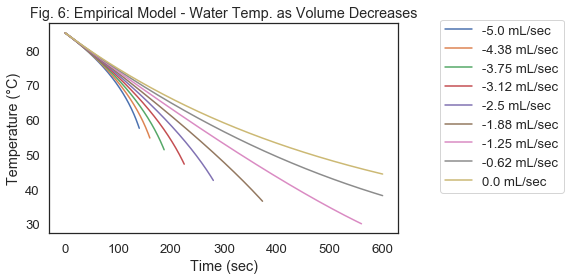

In [14]:
swept2 = sweepdVdt(system, math = False);

dvdt_range = linspace(-5,0,system.n_sweep)
fig = plt.figure()
ax = plt.subplot(111);
for i in range(system.n_sweep):
    dvdt = round(dvdt_range[i], 2)
    ax.plot(swept[i].index, swept2[i].T, label = str(dvdt) + ' mL/sec')
    decorate(xlabel = 'Time (sec)',
            ylabel = 'Temperature (°C)',
            title = 'Fig. 6: Empirical Model - Water Temp. as Volume Decreases'.format(system.t_end))
    ax.legend(bbox_to_anchor=(1.1,1.05))

While fig. 6 is similar to fig. 2, it represents our intuition that this scenario could not have an infinite $dTdt$. We suspect that this is attributable to the container, as it heats up because of the water and does not stay at a constant temperature as the mathematical model assumes. 

### Quantitative Result of Empirical Model

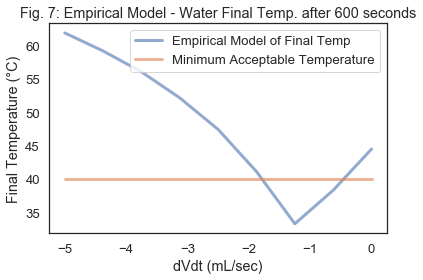

In [46]:
# Creating the time series in which the last temperatures from each dVdt 
# sweep will be stored.
last_temp2 = TimeSeries()
last_temp2 = determine_last_temp(last_temp2, system, swept2)

# To plot the data against dVdt and not against the sweep numbers, the dvdt 
# values and last temperature values will be converted into lists and then
# plotted against each other.
dvdt_list2 = []
last_temp_list2 = []

for i in range(len(dvdt_range)):
    dvdt_list2.append(dvdt_range[i])
    last_temp_list2.append(last_temp2[i])

plot_final_temp_and_minimum_acceptable_temp(dvdt_list, last_temp_list2, 
                                            minimum_acceptable_temp,
                                            'Empirical Model of Final Temp',)

decorate(xlabel = 'dVdt (mL/sec)', 
         ylabel = 'Final Temperature (°C)', 
         title = 'Fig. 7: Empirical Model - '
             'Water Final Temp. after {} seconds'
             .format(system.t_end))

# Interpretation

It is clear that the mathematical model and empirical model sharing share a very strong resemblance, suggesting that that the mathematical model is reasonably accurate. While the mathematical model may predict a near-infinite $dTdt$ at $V$ ≈ 0 (and therefore a result such as room temperature water when $dVdt$ ≈1.88 mL/sec), the empirical model shows that, in reality, this is not measurable. This, too, is backed up by our intuition, which would suggest that liquids do not suddenly become room temperature when $V$ ≈ 0 even if their volume is decreasing. 

Despite the assumptions that we included in our model, we were still able to successfully show the mathematical relationship between decreasing $dTdt$ and $dVdt$ of a fluid in an open vessel. In other words, we have explained the phenomenon of coffee cooling faster as it is consumed: we are able to predict the final temperature of the fluid for a variety of $dVdt$ values. Furthermore, if a minimum acceptable temperature is desired for the water, the $dVdt$ values necessary to produce this temperature or greater can be delineated by the horizontal lines on fig. 3 and fig. 7.

If this model's scope were to be extended, further steps could be taken to more accurately represent mathematically the heat transfer of the system. For example, consideration of the differences in convection between the walls of the container and the air could be added to the model. There could be additional exploration of the insulating properties of other containers and how these differences affect the results of the model. Another addition to this model could be the use of a piecewise function of $dVdt$, simulating more realistically how a person would consume a hot beverage in sips as opposed to a constant volume change.

A relationship to note among the qualitative results: By the argument that there is a point of inflection where the cooling curve created by $dTdt$ over time changes from concave to convex, there must be a value of $dVdt$ for which the curve of $dTdt$ is an entirely linear relationship. Further expansion of this model could look into this relationship, optimizing $dVdt$ such that cooling could be a perfectly linear process.

### Iteration of model:

The model was initially running off of an empirical relationship between $r$ and $V$. Thus, it was not actually a model in the sense of it being completely mathematically based. Upon realization of this shortcoming, we added in a mathematical relationship relationship between $r$ and $V$, and then ran the model on both functions independently to compare the results. Another iteration that was made was adding in a quantitative analysis of the qualitative results. As eye-catching as the qualitative results are with their dovetail pattern of curves, they are not the punchline graphs we need. Therefore, we added in code that extracted data from these qualitative results to provide the punchline graphs of fig. 3 and fig. 7, a more easily interpretable result, and a clear answer to our second question. 

# Abstract

The questions this model attempts to answer are, for an open vessel of water: 
1. How can the relationship between the water's $dVdt$ and $dTdt$ be qualitatively explained?
2. Can the temperature of water be predicted given parameters such as its rate of volume change, information about its container, etc.?

When the model invokes a mathematical function of the r (a number that acts as a coefficient in Newton's Law of cooling) as a function of volume, and the simulation is run for 600 seconds, the final temperature of the water can be predicted as a function of the rate of change of volume over the 600 seconds:

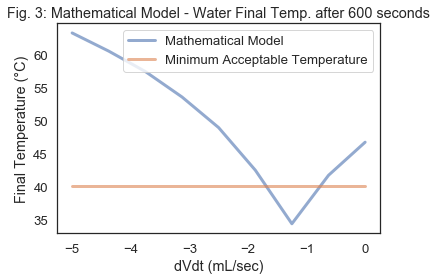

In [48]:
plot_final_temp_and_minimum_acceptable_temp(dvdt_list, last_temp_list, minimum_acceptable_temp, 
                                            'Mathematical Model')
decorate(xlabel = 'dVdt (mL/sec)', 
         ylabel = 'Final Temperature (°C)', 
         title = 'Fig. 3: Mathematical Model - Water Final Temp. after {} seconds'.format(system.t_end))

When the model invokes an empirical function of $r$, an output very similar to the mathematical model results:

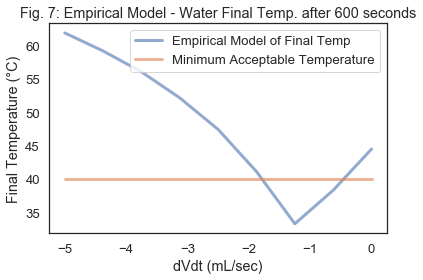

In [50]:
plot_final_temp_and_minimum_acceptable_temp(dvdt_list, last_temp_list2, 
                                            minimum_acceptable_temp,
                                            'Empirical Model of Final Temp',)
decorate(xlabel = 'dVdt (mL/sec)', 
         ylabel = 'Final Temperature (°C)', 
         title = 'Fig. 7: Empirical Model - '
             'Water Final Temp. after {} seconds'
             .format(system.t_end))

Despite the assumptions that we included in our model, we were still able to successfully show the mathematical relationship between decreasing $dTdt$ and $dVdt$ of a fluid in an open vessel. In other words, given the necessary parameters, we are able to predict the final temperature of the fluid for a variety of $dVdt$ values.